# LightGBM Classifier - Fraud Detection

<img src="images/frauddetection.jpg"/>

Data source: https://www.kaggle.com/c/ieee-fraud-detection/data

The data is broken into two files 'identity' and 'transaction', which are joined by 'TransactionID'. Not all transactions have corresponding identity information.

Categorical Features - Transaction

* ProductCD
* card1 - card6
* addr1, addr2
* P_emaildomain
* R_emaildomain
* M1 - M9

Categorical Features - Identity

* DeviceType
* DeviceInfo
* id_12 - id_38

The TransactionDT feature is a timedelta from a given reference datetime (not an actual timestamp).

### General Libraries

In [1]:
import pandas as pd
import dask.dataframe as dd
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

### Load the Data

In [2]:
transaction = dd.read_csv("data/train_transaction.csv")

transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# Let's see the types of values
transaction.dtypes

TransactionID       int64
isFraud             int64
TransactionDT       int64
TransactionAmt    float64
ProductCD          object
                   ...   
V335              float64
V336              float64
V337              float64
V338              float64
V339              float64
Length: 394, dtype: object

### Data Mining

In [4]:
# Select some columns to use as a training data

transaction = transaction[['isFraud','TransactionAmt','ProductCD','card1','card2','card3','card4','card5','card6',
                           'addr1','addr2','dist1','dist2','P_emaildomain','R_emaildomain','C1','C2','C3','C4','C5',
                           'C6','C7','C8','C9','C10','C11','C12','C13','C14','D1','D2','D3','D4','D5','D6','D7','D8',
                           'D9','D10','D11','D12','D13','D14','D15']].compute()

In [5]:
transaction.dtypes

isFraud             int64
TransactionAmt    float64
ProductCD          object
card1               int64
card2             float64
card3             float64
card4              object
card5             float64
card6              object
addr1             float64
addr2             float64
dist1             float64
dist2             float64
P_emaildomain      object
R_emaildomain      object
C1                float64
C2                float64
C3                float64
C4                float64
C5                float64
C6                float64
C7                float64
C8                float64
C9                float64
C10               float64
C11               float64
C12               float64
C13               float64
C14               float64
D1                float64
D2                float64
D3                float64
D4                float64
D5                float64
D6                float64
D7                float64
D8                float64
D9                float64
D10         

In [6]:
# Select the categorical features
categorical_features = ['ProductCD','card4','card6','P_emaildomain','R_emaildomain']

In [7]:
# Encode categorical features as integer

from category_encoders import OrdinalEncoder                                                  

ordinal_encoder = OrdinalEncoder(cols = categorical_features, handle_missing='return_nan')    

transaction = ordinal_encoder.fit_transform(transaction)

transaction.head()

,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
0,0,68.5,1.0,13926,NaN,150.0,1.0,142.0,1.0,315.0,...,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0
1,0,29.0,1.0,2755,404.0,150.0,2.0,102.0,1.0,325.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0
2,0,59.0,1.0,4663,490.0,150.0,3.0,166.0,2.0,330.0,...,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0
3,0,50.0,1.0,18132,567.0,150.0,2.0,117.0,2.0,476.0,...,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0
4,0,50.0,2.0,4497,514.0,150.0,2.0,102.0,1.0,420.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Split the Data

In [8]:
X = transaction.drop(['isFraud'],axis=1)  # Indepedent variable

y = transaction['isFraud']                # Dependent variable

In [9]:
# Verify output
y.unique()

array([0, 1], dtype=int64)

In [10]:
# Lets see how imbalance is this dataset looking for y=1:
sum(y) / len(y)

0.03499000914417313

In [11]:
# Split in Training data and Test data

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, stratify=y)

In [12]:
# Let's see if stratify worked as expected, creating groups with the same proportion of 1's and 0's.

print(sum(y_train) / len(y_train))
print(sum(y_test) / len(y_test))

0.034989767234831076
0.03499057359930459


### Build LGBM Model

In [13]:
from lightgbm import LGBMClassifier  # Import library

model = LGBMClassifier()             # Create shell

model.fit(X_train,     # Training data
          y_train,     # Training data
          verbose=True,                 # Verbosity of printing messages
          eval_metric='aucpr',          # Area under the PR curve
          eval_set=[(X_test,y_test)])   # Train with the train dataset, but evaluete the how many trees with the test dataset 

[1]	valid_0's binary_logloss: 0.129248
[2]	valid_0's binary_logloss: 0.123716
[3]	valid_0's binary_logloss: 0.119423
[4]	valid_0's binary_logloss: 0.115976
[5]	valid_0's binary_logloss: 0.113456
[6]	valid_0's binary_logloss: 0.111157
[7]	valid_0's binary_logloss: 0.109195
[8]	valid_0's binary_logloss: 0.107268
[9]	valid_0's binary_logloss: 0.105685
[10]	valid_0's binary_logloss: 0.104286
[11]	valid_0's binary_logloss: 0.103128
[12]	valid_0's binary_logloss: 0.101899
[13]	valid_0's binary_logloss: 0.100864
[14]	valid_0's binary_logloss: 0.0999718
[15]	valid_0's binary_logloss: 0.0991291
[16]	valid_0's binary_logloss: 0.0982416
[17]	valid_0's binary_logloss: 0.0974102
[18]	valid_0's binary_logloss: 0.0967603
[19]	valid_0's binary_logloss: 0.0959399
[20]	valid_0's binary_logloss: 0.0953404
[21]	valid_0's binary_logloss: 0.094826
[22]	valid_0's binary_logloss: 0.0943897
[23]	valid_0's binary_logloss: 0.0938639
[24]	valid_0's binary_logloss: 0.0933623
[25]	valid_0's binary_logloss: 0.092998

LGBMClassifier()

In [14]:
# Make Predictions
predictions = model.predict(X_test)

### Results obtained

In [15]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score

In [16]:
accuracy_score(predictions, y_test)

0.9772129463428952

In [17]:
confusion_matrix(predictions, y_test)

array([[170600,   3674],
       [   363,   2525]], dtype=int64)

In [18]:
from sklearn.metrics import plot_confusion_matrix

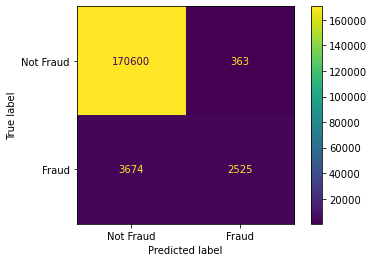

In [19]:
# Plot Confusion Matrix

plot_confusion_matrix(model,              # estimator
                      X_test,             # X
                      y_test,             # y-true
                      values_format='d',
                      display_labels=['Not Fraud', 'Fraud'])

In [20]:
print(classification_report(predictions, y_test))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    174274
           1       0.41      0.87      0.56      2888

    accuracy                           0.98    177162
   macro avg       0.70      0.93      0.77    177162
weighted avg       0.99      0.98      0.98    177162



### Plot Tree

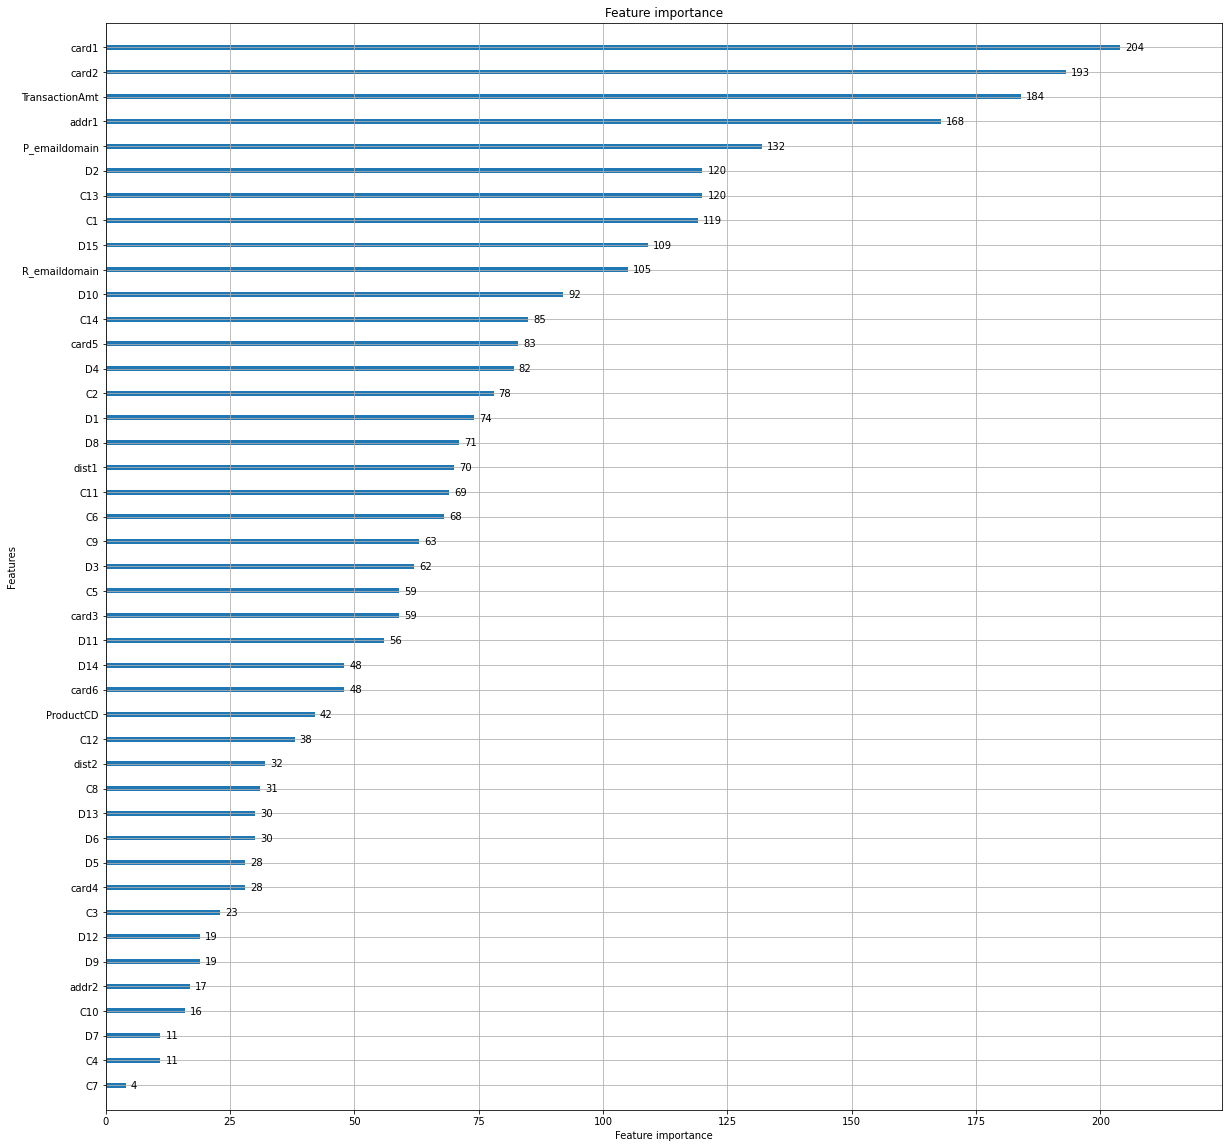

In [21]:
_ = lgb.plot_importance(model, figsize=(20, 20)) # feature importance

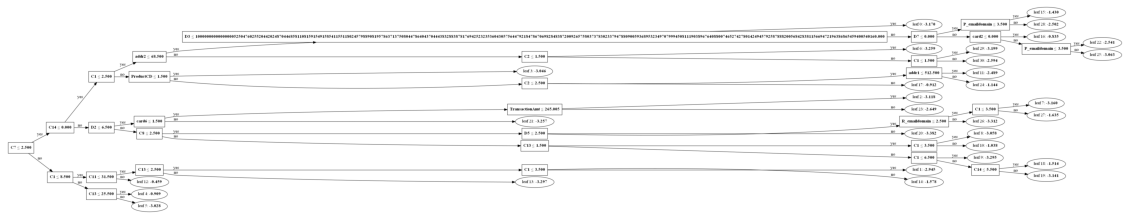

In [22]:
_ = lgb.plot_tree(model, figsize=(20, 20)) # built trees

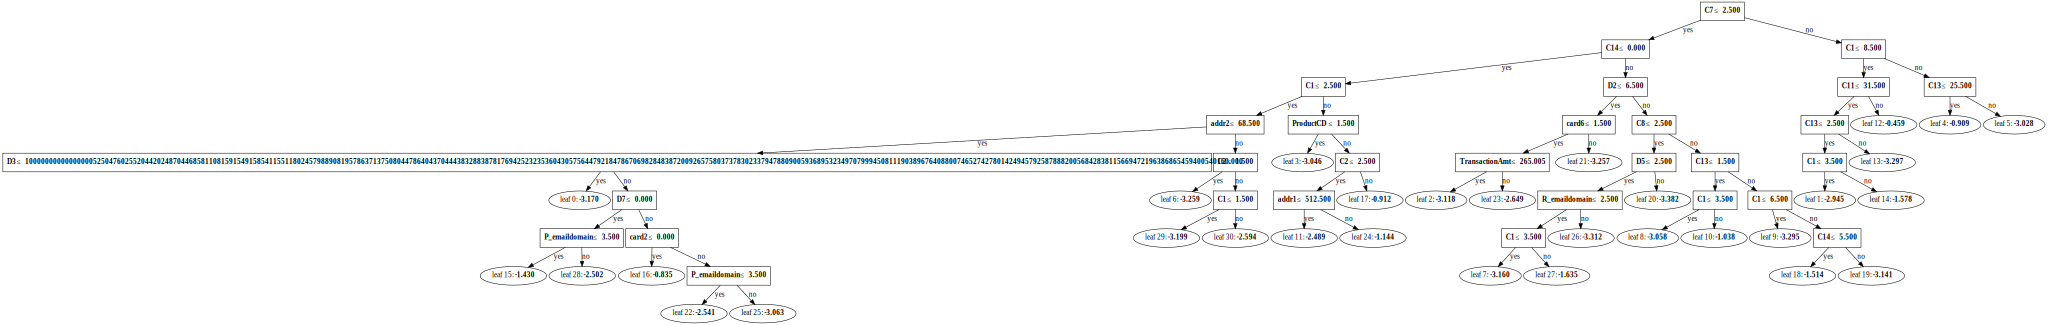

In [23]:
lgb.create_tree_digraph(model, orientation='vertical')